In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter
import scipy.sparse as sp
from scipy.sparse import hstack
import xgboost as xgb
import time
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data = pd.read_csv('MyDrive/Colab Notebooks/WikiLarge_Train.csv', encoding="utf-8")
data.head()

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1


### Pre-processing

In [ ]:
def clean(data):
    # create a new column of text data, lower case all words 
    data["cleaned_text"] = data['original_text'].str.lower()

    # remove "-LRB-", "-LRB-", non-alphabets and non-ascii characters
    data['cleaned_text'] = data['cleaned_text'].str.replace("-lrb-", '')
    data['cleaned_text'] = data['cleaned_text'].str.replace("-rrb-", '')
    data["cleaned_text"] = data["cleaned_text"].str.encode('ascii', 'ignore').str.decode('ascii')

    # remove space >1
    data["cleaned_text"] = data["cleaned_text"].str.replace('[\s]{2,}', ' ')

    # remove space at the begining and the end of each sentence
    data["cleaned_text"] = data["cleaned_text"].str.strip()
    return data

In [ ]:
# cleaned data
data = clean(data)

In [ ]:
# check no non-ascii characters
count = 0
for sentence in data['cleaned_text']:
    if sentence.isascii() == False:
        count += 1
count

0

In [ ]:
def lemmatization(row):
    #make sure nltk.download('stopwords') and nltk.download('wordnet') work 
    
    stop = list(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    token_words= word_tokenize(row)
    token_words = [word for word in token_words if not word in stop]
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(lemmatizer.lemmatize(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# length of the sentence could be a indicator of complexity
# add a column of length to the data (this process takes a few minutes)

data['length'] = data['cleaned_text'].apply(lambda x: len(lemmatization(x).strip().split(" ")))
data.head()

,original_text,label,cleaned_text,length
0,There is manuscript evidence that Austen conti...,1,there is manuscript evidence that austen conti...,25
1,"In a remarkable comparative analysis , Mandaea...",1,"in a remarkable comparative analysis , mandaea...",17
2,"Before Persephone was released to Hermes , who...",1,"before persephone was released to hermes , who...",23
3,Cogeneration plants are commonly found in dist...,1,cogeneration plants are commonly found in dist...,34
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,"geneva , ; , ; , ; ; is the second-most-populo...",19


In [ ]:
# use POS tagging to create additional features as indicators of complexity
# In corpus linguistics, part-of-speech tagging (POS tagging or PoS tagging or POST), 
# also called grammatical tagging is the process of marking up a word in a text (corpus) as corresponding 
# to a particular part of speech, based on both its definition and its context.

def pos(data):
    pos_li = []
    for row in data['cleaned_text']:
        tokens = word_tokenize(row)
        pos = nltk.pos_tag(tokens)
        count = Counter(elem[1] for elem in pos)
        pos_li.append(count)
    pos_df = pd.DataFrame(pos_li)  
    pos_df = pos_df.fillna(0)
    return pos_df

In [ ]:
# run above function to get a new df of POS takes about 15mins
# so I have saved the df in advance
# load this file

pos_df = pd.read_csv("MyDrive/Colab Notebooks/pos_df.csv")
pos_df.head()

,EX,VBZ,JJ,NN,WDT,VBN,TO,VB,IN,DT,NNS,RB,CD,``,",",CC,PRP$,VBD,.,POS,WP,PRP,VBG,VBP,:,RBS,WRB,NNP,JJS,MD,JJR,RP,RBR,#,FW,'',SYM,WP$,$,PDT,UH,NNPS,LS
0,1.0,2.0,2.0,5.0,1.0,1.0,1.0,1.0,4.0,2.0,3.0,6.0,3.0,1.0,3.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,4.0,6.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,5.0,1.0,3.0,5.0,2.0,3.0,4.0,2.0,0.0,2.0,0.0,3.0,1.0,1.0,4.0,1.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,2.0,9.0,0.0,1.0,0.0,0.0,3.0,0.0,11.0,1.0,0.0,0.0,6.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,3.0,7.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# the same for WikiLarge_Train data
# make sure it has the same order of columns as the train data

cols = pos_df.columns
pos_test_df = pd.read_csv("MyDrive/Colab Notebooks/pos_test_df.csv")
pos_test_df = pos_test_df[cols]
pos_test_df.head()

,EX,VBZ,JJ,NN,WDT,VBN,TO,VB,IN,DT,NNS,RB,CD,``,",",CC,PRP$,VBD,.,POS,WP,PRP,VBG,VBP,:,RBS,WRB,NNP,JJS,MD,JJR,RP,RBR,#,FW,'',SYM,WP$,$,PDT,UH,NNPS,LS
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


xgboost model

1. tuning the xgboost model using a pipeline and hold parameters in tfidf constant max_features=10000, ngram_range=(1,3), min_df=6, max_df=0.85

In [ ]:
X = data[['cleaned_text', 'length']]
y = data['label']

In [ ]:
# train dataset 80%, test dataset 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# vectorize the text data (this cell takes a while to run)
tfidf = TfidfVectorizer(analyzer='word', max_features=10000, ngram_range=(1,3), min_df=6, max_df=0.85,
                     preprocessor=lemmatization)

X_train_text_tfidf = tfidf.fit_transform(X_train['cleaned_text'])
X_test_text_tfidf = tfidf.transform(X_test['cleaned_text'])

In [ ]:
vocab = tfidf.vocabulary_ 
names = tfidf.get_feature_names()

In [ ]:
# increase the weight of those words from the additional dataset
# in the document term matrix

dale_chall = pd.read_csv("MyDrive/Colab Notebooks/dale_chall.txt", header = None)
dale_list = dale_chall[0].values
# dale_list

for w in dale_list:
    if w in names:
        index = vocab[w]
        X_train_text_tfidf[:, index] *= 3
        X_test_text_tfidf[:, index] *= 3      

In [ ]:
# combine document term matrix with the length column
X_train_text_length = hstack([X_train_text_tfidf, X_train["length"].to_numpy().reshape(-1,1)])
X_test_text_length = hstack([X_test_text_tfidf, X_test["length"].to_numpy().reshape(-1,1)])

In [ ]:
# combine above (X_train_text_length and X_test_text_length) with pos df
# first split pos df to 80/20 then stack the data 
X_pos = pos_df
y = data['label']
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X_pos, y, test_size=0.2, random_state=42)
# pos_sparse = sp.csr_matrix(pos_df.values)

X_train_text_poslength = hstack([X_train_text_length, X_train_pos])
X_test_text_poslength = hstack([X_test_text_length, X_test_pos])

In [ ]:
clf = xgb.XGBClassifier()

In [ ]:
params = [{"clf__n_estimators":[1000], #[100,500,1000],
           "clf__max_depth":[35], #[20,30,40],
           "clf__learning_rate":[0.01], #[0.1,0.01],
          "clf__subsample":[0.8], #[0.8,1],
           "clf__colsample_bytree":[0.6], #[0.6,0.8,1],
           "clf__gamma":[1],
           "clf__objective":['binary:logistic'],
            "clf__reg_alpha ":[0.3],
           "clf__scale_pos_weight": [1] 
}]

In [ ]:
grid_search1 = GridSearchCV(clf, params, cv=5, n_jobs=1)

In [ ]:
t0 = time.time()
xg_model1 = grid_search1.fit(X_train_text_poslength, y_train)
t1 = time.time()
print(f"time = {(t1-t0) /60} mins")

time = 4.739090236028035 mins


In [ ]:
print(xg_model1.best_score_)
print(xg_model1.best_params_)

0.6789996887312203
{'clf__colsample_bytree': 0.6, 'clf__gamma': 1, 'clf__learning_rate': 0.01, 'clf__max_depth': 35, 'clf__n_estimators': 1000, 'clf__objective': 'binary:logistic', 'clf__reg_alpha ': 0.3, 'clf__scale_pos_weight': 1, 'clf__subsample': 0.8}


In [ ]:
preds_pos = xg_model1.predict(X_test_text_poslength)
preds_pos

array([1, 0, 0, ..., 1, 0, 0])

In [ ]:
accuracy_score(y_test, preds_pos)

0.6806272044532956

In [ ]:
print(metrics.classification_report(y_test, preds_pos))

              precision    recall  f1-score   support

           0       0.68      0.67      0.68     41549
           1       0.68      0.69      0.69     41805

    accuracy                           0.68     83354
   macro avg       0.68      0.68      0.68     83354
weighted avg       0.68      0.68      0.68     83354



In [ ]:
prob_0 = xg_model1.predict_proba(X_test_text_poslength)[:,0]
prob_1 = xg_model1.predict_proba(X_test_text_poslength)[:,1]

In [ ]:
# calculate roc curves
fpr1, tpr1, _ = roc_curve(y_test, prob_1)

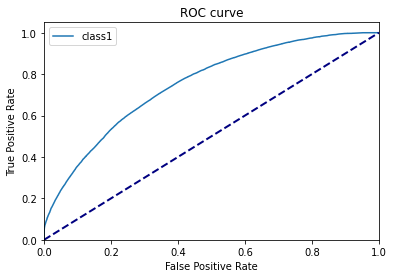

In [ ]:
plt.plot(fpr1, tpr1, label='class1')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, prob_1)

No handles with labels found to put in legend.


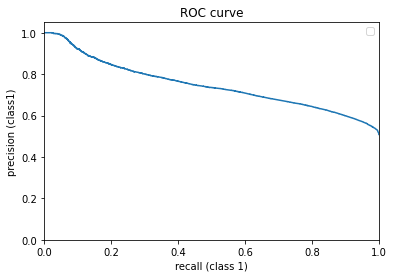

In [ ]:
plt.plot(recall, precision)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('recall (class 1)')
plt.ylabel('precision (class1)')
plt.title('ROC curve')
plt.legend()

2. tuning the xgboost model using a pipeline and hold parameters in tfidf constant max_features=20000, ngram_range=(1,2), min_df=9, max_df=0.9

In [ ]:
tfidf1 = TfidfVectorizer(analyzer='word', max_features=20000, ngram_range=(1,2), min_df=8, max_df=0.9,
                     preprocessor=lemmatization)

X_train_text_tfidf1 = tfidf1.fit_transform(X_train['cleaned_text'])
X_test_text_tfidf1 = tfidf1.transform(X_test['cleaned_text'])

vocab1 = tfidf1.vocabulary_ 
names1 = tfidf1.get_feature_names()

In [ ]:
# combine document term matrix with the length column
X_train_text_length1 = hstack([X_train_text_tfidf1, X_train["length"].to_numpy().reshape(-1,1)])
X_test_text_length1 = hstack([X_test_text_tfidf1, X_test["length"].to_numpy().reshape(-1,1)])

In [ ]:
# combine above (X_train_text_length and X_test_text_length) with pos df
# first split pos df to 80/20 then stack the data 
X_pos = pos_df
y = data['label']
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X_pos, y, test_size=0.2, random_state=42)
# pos_sparse = sp.csr_matrix(pos_df.values)

X_train_text_poslength1 = hstack([X_train_text_length1, X_train_pos])
X_test_text_poslength1 = hstack([X_test_text_length1, X_test_pos])

In [ ]:
params1 = [{"clf__n_estimators":[1000],#[2000,4000],
           "clf__max_depth":[30,35],
           "clf__learning_rate":[0.1,0.01],
          "clf__subsample":[0.8],
           "clf__colsample_bytree":[0.6],
           "clf__gamma":[1],
           "clf__objective":['binary:logistic'],
            "clf__reg_alpha ":[0.3],
           "clf__scale_pos_weight": [1] 
}]

In [ ]:
grid_search2 = GridSearchCV(clf, params1, cv=5, n_jobs=1)

In [ ]:
t0 = time.time()
xg_model2 = grid_search2.fit(X_train_text_poslength1, y_train)
t1 = time.time()
print(f"time = {(t1-t0) /60} mins")

time = 17.398496814568837 mins


In [ ]:
print(xg_model2.best_score_)
print(xg_model2.best_params_)

0.6791526523798677
{'clf__colsample_bytree': 0.6, 'clf__gamma': 1, 'clf__learning_rate': 0.1, 'clf__max_depth': 30, 'clf__n_estimators': 1000, 'clf__objective': 'binary:logistic', 'clf__reg_alpha ': 0.3, 'clf__scale_pos_weight': 1, 'clf__subsample': 0.8}


In [ ]:
preds_pos2 = xg_model2.predict(X_test_text_poslength1)
accuracy_score(y_test, preds_pos2)

0.6802073085874704

In [ ]:
# write a loop to check how max_feature affects accuracy

def maxfeature_eval(features,X_train,X_test,pos_df,data):    
  tfidf = TfidfVectorizer(analyzer='word', max_features=features, ngram_range=(1,2), min_df=6, max_df=0.9,)
                    #  preprocessor=lemmatization)
  X_train_text_tfidf = tfidf.fit_transform(X_train['cleaned_text'])
  X_test_text_tfidf = tfidf.transform(X_test['cleaned_text'])
  X_train_text_length = hstack([X_train_text_tfidf, X_train["length"].to_numpy().reshape(-1,1)])
  X_test_text_length = hstack([X_test_text_tfidf, X_test["length"].to_numpy().reshape(-1,1)])
  X_pos = pos_df
  y = data['label']
  X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X_pos, y, test_size=0.2, random_state=42)

  X_train_text_poslength = hstack([X_train_text_length, X_train_pos])
  X_test_text_poslength = hstack([X_test_text_length, X_test_pos])
  return X_train_text_poslength, X_test_text_poslength


In [ ]:
params2 = [{"clf__n_estimators":[1000],#[2000,4000],
           "clf__max_depth":[25,30],
           "clf__learning_rate":[0.01],
          "clf__subsample":[0.8],
           "clf__colsample_bytree":[0.6],
           "clf__gamma":[1],
           "clf__objective":['binary:logistic'],
            "clf__reg_alpha ":[0.3],
           "clf__scale_pos_weight": [1] 
}]

In [ ]:
clf = xgb.XGBClassifier()
grid_search3 = GridSearchCV(clf, params2, cv=5, n_jobs=1)

In [ ]:
res = []
for feature in [5000, 10000, 15000, 20000, 25000, 30000, 40000, 50000]:
  res.append(maxfeature_eval(feature,X_train,X_test,pos_df,data))
len(res)

8

In [ ]:
# get the first item in the tuple
res_f = []
for t in res:
  res_f.append(t[0])
len(res_f)

8

In [ ]:
res_f

[<333414x5044 sparse matrix of type '<class 'numpy.float64'>'
 	with 9007946 stored elements in COOrdinate format>,
 <333414x10044 sparse matrix of type '<class 'numpy.float64'>'
 	with 9693283 stored elements in COOrdinate format>,
 <333414x15044 sparse matrix of type '<class 'numpy.float64'>'
 	with 10088562 stored elements in COOrdinate format>,
 <333414x20044 sparse matrix of type '<class 'numpy.float64'>'
 	with 10365887 stored elements in COOrdinate format>,
 <333414x25044 sparse matrix of type '<class 'numpy.float64'>'
 	with 10578893 stored elements in COOrdinate format>,
 <333414x30044 sparse matrix of type '<class 'numpy.float64'>'
 	with 10751810 stored elements in COOrdinate format>,
 <333414x40044 sparse matrix of type '<class 'numpy.float64'>'
 	with 11022263 stored elements in COOrdinate format>,
 <333414x50044 sparse matrix of type '<class 'numpy.float64'>'
 	with 11230015 stored elements in COOrdinate format>]

In [ ]:
test = grid_search3.fit(res_f[0], y_train)

In [ ]:
test.best_score_

0.6816330513405907

In [ ]:
test1 = grid_search3.fit(res_f[1], y_train)

In [ ]:
test1.best_score_

0.6817380257118492

In [ ]:
test2 = grid_search3.fit(res_f[2], y_train)
test2.best_score_

0.6816150547599806

In [ ]:
test3 = grid_search3.fit(res_f[3], y_train)
test3.best_score_

0.6813991075320825

In [ ]:
test4 = grid_search3.fit(res_f[7], y_train)
test4.best_score_

In [ ]:
t0 = time.time()
best_models = []
for x in res_f:
  xg_model2 = grid_search3.fit(x, y_train)
  best_models.append(xg_model2)
  t1 = time.time()
  print(f"time = {(t1-t0) /60} mins")

time = 12.15883785088857 mins
time = 25.568058653672537 mins
time = 39.646129322052005 mins
time = 54.349635223547615 mins
time = 69.47328737179438 mins
time = 85.02292761405309 mins
time = 101.19039036432902 mins
time = 117.91441212097804 mins


In [ ]:
len(best_models)

8

In [ ]:
# now we have the input data ready. we can fit the model

model_pos = xgb.XGBClassifier(#num_class=2, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.6,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=35, 
                      gamma=1)

In [ ]:
# it takes hours to run 800 iterations. so I have saved the trained model 
# comment out below to save time
eval_set = [(X_train_text_poslength, y_train), (X_test_text_poslength, y_test)]
eval_metric = ["error"]

In [ ]:
model_pos.fit(X_train_text_poslength, y_train, eval_metric=eval_metric, 
              eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.27906	validation_1-error:0.32307
[1]	validation_0-error:0.24443	validation_1-error:0.31877
[2]	validation_0-error:0.24227	validation_1-error:0.31159
[3]	validation_0-error:0.23402	validation_1-error:0.30638
[4]	validation_0-error:0.23591	validation_1-error:0.30278
[5]	validation_0-error:0.23525	validation_1-error:0.30206
[6]	validation_0-error:0.22972	validation_1-error:0.30044
[7]	validation_0-error:0.22870	validation_1-error:0.29905
[8]	validation_0-error:0.22886	validation_1-error:0.29731
[9]	validation_0-error:0.23010	validation_1-error:0.29683
[10]	validation_0-error:0.23061	validation_1-error:0.29658
[11]	validation_0-error:0.22848	validation_1-error:0.29490
[12]	validation_0-error:0.22626	validation_1-error:0.29461
[13]	validation_0-error:0.22711	validation_1-error:0.29412
[14]	validation_0-error:0.22639	validation_1-error:0.29388
[15]	validation_0-error:0.22440	validation_1-error:0.29363
[16]	validation_0-error:0.22517	validation_1-error:0.29350
[17]	va

[139]	validation_0-error:0.20308	validation_1-error:0.28385
[140]	validation_0-error:0.20280	validation_1-error:0.28367
[141]	validation_0-error:0.20256	validation_1-error:0.28366
[142]	validation_0-error:0.20239	validation_1-error:0.28374
[143]	validation_0-error:0.20220	validation_1-error:0.28354
[144]	validation_0-error:0.20203	validation_1-error:0.28351
[145]	validation_0-error:0.20171	validation_1-error:0.28331
[146]	validation_0-error:0.20164	validation_1-error:0.28349
[147]	validation_0-error:0.20146	validation_1-error:0.28343
[148]	validation_0-error:0.20145	validation_1-error:0.28343
[149]	validation_0-error:0.20121	validation_1-error:0.28335
[150]	validation_0-error:0.20104	validation_1-error:0.28279
[151]	validation_0-error:0.20077	validation_1-error:0.28287
[152]	validation_0-error:0.20059	validation_1-error:0.28285
[153]	validation_0-error:0.20049	validation_1-error:0.28294
[154]	validation_0-error:0.20019	validation_1-error:0.28275
[155]	validation_0-error:0.20010	validat

[276]	validation_0-error:0.18861	validation_1-error:0.27781
[277]	validation_0-error:0.18855	validation_1-error:0.27774
[278]	validation_0-error:0.18847	validation_1-error:0.27766
[279]	validation_0-error:0.18848	validation_1-error:0.27755
[280]	validation_0-error:0.18845	validation_1-error:0.27750
[281]	validation_0-error:0.18841	validation_1-error:0.27743
[282]	validation_0-error:0.18829	validation_1-error:0.27746
[283]	validation_0-error:0.18826	validation_1-error:0.27747
[284]	validation_0-error:0.18812	validation_1-error:0.27758
[285]	validation_0-error:0.18806	validation_1-error:0.27752
[286]	validation_0-error:0.18793	validation_1-error:0.27762
[287]	validation_0-error:0.18783	validation_1-error:0.27755
[288]	validation_0-error:0.18784	validation_1-error:0.27748
[289]	validation_0-error:0.18774	validation_1-error:0.27733
[290]	validation_0-error:0.18757	validation_1-error:0.27736
[291]	validation_0-error:0.18758	validation_1-error:0.27737
[292]	validation_0-error:0.18756	validat

[413]	validation_0-error:0.18055	validation_1-error:0.27497
[414]	validation_0-error:0.18053	validation_1-error:0.27503
[415]	validation_0-error:0.18049	validation_1-error:0.27501
[416]	validation_0-error:0.18048	validation_1-error:0.27501
[417]	validation_0-error:0.18047	validation_1-error:0.27486
[418]	validation_0-error:0.18041	validation_1-error:0.27494
[419]	validation_0-error:0.18029	validation_1-error:0.27491
[420]	validation_0-error:0.18029	validation_1-error:0.27497
[421]	validation_0-error:0.18019	validation_1-error:0.27490
[422]	validation_0-error:0.18012	validation_1-error:0.27482
[423]	validation_0-error:0.18007	validation_1-error:0.27492
[424]	validation_0-error:0.18001	validation_1-error:0.27484
[425]	validation_0-error:0.17995	validation_1-error:0.27485
[426]	validation_0-error:0.17987	validation_1-error:0.27477
[427]	validation_0-error:0.17975	validation_1-error:0.27466
[428]	validation_0-error:0.17968	validation_1-error:0.27456
[429]	validation_0-error:0.17966	validat

[550]	validation_0-error:0.17414	validation_1-error:0.27270
[551]	validation_0-error:0.17410	validation_1-error:0.27275
[552]	validation_0-error:0.17406	validation_1-error:0.27274
[553]	validation_0-error:0.17400	validation_1-error:0.27272
[554]	validation_0-error:0.17388	validation_1-error:0.27270
[555]	validation_0-error:0.17381	validation_1-error:0.27272
[556]	validation_0-error:0.17380	validation_1-error:0.27273
[557]	validation_0-error:0.17378	validation_1-error:0.27270
[558]	validation_0-error:0.17372	validation_1-error:0.27268
[559]	validation_0-error:0.17368	validation_1-error:0.27266
[560]	validation_0-error:0.17367	validation_1-error:0.27267
[561]	validation_0-error:0.17360	validation_1-error:0.27257
[562]	validation_0-error:0.17357	validation_1-error:0.27257
[563]	validation_0-error:0.17352	validation_1-error:0.27254
[564]	validation_0-error:0.17347	validation_1-error:0.27252
[565]	validation_0-error:0.17341	validation_1-error:0.27255
[566]	validation_0-error:0.17336	validat

[687]	validation_0-error:0.16856	validation_1-error:0.27117
[688]	validation_0-error:0.16854	validation_1-error:0.27111
[689]	validation_0-error:0.16848	validation_1-error:0.27105
[690]	validation_0-error:0.16848	validation_1-error:0.27104
[691]	validation_0-error:0.16841	validation_1-error:0.27106
[692]	validation_0-error:0.16838	validation_1-error:0.27107
[693]	validation_0-error:0.16839	validation_1-error:0.27106
[694]	validation_0-error:0.16836	validation_1-error:0.27111
[695]	validation_0-error:0.16828	validation_1-error:0.27111
[696]	validation_0-error:0.16824	validation_1-error:0.27103
[697]	validation_0-error:0.16822	validation_1-error:0.27109
[698]	validation_0-error:0.16817	validation_1-error:0.27109
[699]	validation_0-error:0.16813	validation_1-error:0.27106
[700]	validation_0-error:0.16808	validation_1-error:0.27103
[701]	validation_0-error:0.16804	validation_1-error:0.27103
[702]	validation_0-error:0.16800	validation_1-error:0.27103
[703]	validation_0-error:0.16797	validat

[824]	validation_0-error:0.16346	validation_1-error:0.26949
[825]	validation_0-error:0.16342	validation_1-error:0.26943
[826]	validation_0-error:0.16341	validation_1-error:0.26947
[827]	validation_0-error:0.16339	validation_1-error:0.26948
[828]	validation_0-error:0.16336	validation_1-error:0.26945
[829]	validation_0-error:0.16331	validation_1-error:0.26944
[830]	validation_0-error:0.16331	validation_1-error:0.26945
[831]	validation_0-error:0.16330	validation_1-error:0.26941
[832]	validation_0-error:0.16329	validation_1-error:0.26941
[833]	validation_0-error:0.16321	validation_1-error:0.26943
[834]	validation_0-error:0.16318	validation_1-error:0.26935
[835]	validation_0-error:0.16316	validation_1-error:0.26935
[836]	validation_0-error:0.16313	validation_1-error:0.26939
[837]	validation_0-error:0.16307	validation_1-error:0.26941
[838]	validation_0-error:0.16304	validation_1-error:0.26941
[839]	validation_0-error:0.16302	validation_1-error:0.26937
[840]	validation_0-error:0.16299	validat

[961]	validation_0-error:0.15924	validation_1-error:0.26909
[962]	validation_0-error:0.15920	validation_1-error:0.26907
[963]	validation_0-error:0.15913	validation_1-error:0.26912
[964]	validation_0-error:0.15910	validation_1-error:0.26909
[965]	validation_0-error:0.15906	validation_1-error:0.26913
[966]	validation_0-error:0.15902	validation_1-error:0.26914
[967]	validation_0-error:0.15898	validation_1-error:0.26918
[968]	validation_0-error:0.15894	validation_1-error:0.26920
[969]	validation_0-error:0.15896	validation_1-error:0.26918
[970]	validation_0-error:0.15894	validation_1-error:0.26918
[971]	validation_0-error:0.15889	validation_1-error:0.26915
[972]	validation_0-error:0.15887	validation_1-error:0.26915
[973]	validation_0-error:0.15887	validation_1-error:0.26916
[974]	validation_0-error:0.15880	validation_1-error:0.26920
[975]	validation_0-error:0.15877	validation_1-error:0.26922
[976]	validation_0-error:0.15871	validation_1-error:0.26926
[977]	validation_0-error:0.15866	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=35,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
preds_pos = model_pos.predict(X_test_text_poslength)
preds_pos

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [ ]:
# the score from my previous messy notebook is actually 0.7303428, but I cant find out why it has changed
# but it follows the same logic
accuracy_score(y_test, preds_pos)

0.7309427262039014

In [ ]:
# save the model to disk
filename = 'xgboost_pos_model3.pkl'
pickle.dump(model_pos, open(filename, 'wb'))

### Generate results with the test data

In [ ]:
testset = pd.read_csv("WikiLarge_Test.csv", index_col=None)
clean_test = clean(testset)
clean_test['length'] = clean_test['cleaned_text'].apply(lambda x: len(lemmatization(x).strip().split(" ")))
clean_test.head()

,id,original_text,label,cleaned_text,length
0,0,-2011,NaN,-2011,1
1,1,-2011,NaN,-2011,1
2,2,-2000,NaN,-2000,1
3,3,-1997,NaN,-1997,1
4,4,1.636,NaN,1.636,1


In [ ]:
test_data = tfidf.transform(clean_test['cleaned_text'])
for w in dale_list:
    if w in names:
        index = vocab[w]
        test_data[:, index] *= 3

In [ ]:
test_data_length = hstack([test_data, clean_test["length"].to_numpy().reshape(-1,1)])
pos_test_df_sparse = sp.csr_matrix(pos_test_df.values)

In [ ]:
# combine pos test data and test_data_length
test_data_poslength = hstack([test_data_length, pos_test_df_sparse])

In [ ]:
# load the model from disk
model_load = pickle.load(open("xgboost_pos_model3.pkl", "rb"))

In [ ]:
bst_pos_predict = model_load.predict(test_data_poslength)
bst_pos_predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
testset["label"] = bst_pos_predict
res = testset[['id','label']]
res.head()

,id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
res.to_csv("xgboost_pos3.csv", header="ID,Category", index=False) 